# Выпускной проект "Банки — Анализ оттока клиентов"

<a id='materials'></a>
## Материалы

#Презентация: <https://disk.yandex.ru/d/n-cDKIVJYBJxLQ> 

#Дашборд: https://public.tableau.com/app/profile/polina.keresten/viz/FinalProjectBanksDashboard/DashboardBanks

<a id='description'></a>
## Описание и задачи проекта

### Описание

Вы работаете аналитиком данных в банке «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск. Предоставленный датасет содержит данные о клиентах банка. На основании данных требуется выполнить анализ отточности клиентов и ответить на вопросы руководства банка: выделить характеристики повышенной отточности, сравнить портреты типичных клиентов, которые склонны и не склонны уходить из банка.

### Цели и задачи

1. Проанализировать клиентов регионального банка и выделить сегменты клиентов, которые склонны уходить из банка.
2. Объединяя признаки отточности, сформировать сегменты, отобрать из них лучшие (т.е. те, где процент оттока самый высокий) и дать по ним рекомендации.

<a id='open_data'></a>
## Открытие файла данных, знакомство с датафреймом

In [323]:
#импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Accent')
import plotly.express as px

### Чтение данных read_csv 

In [324]:
#откроем файлы
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv')  
    #data = pd.read_csv('/datasets/bank_scrooge.csv') можно так
except:
    data = pd.read_csv('\C:\DA\datasets\bank_scrooge.csv')

data.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [325]:
#посчитаем общий процент оттока по банку
churn_rate=data[data['churn']==1]['churn'].count()/len(data)*100
print('Общий отток по банку:', churn_rate, '%')

Общий отток по банку: 18.2 %


### Вывод информации о датафрейме 

In [326]:
#выведем информацию о датафрейме с помощью функции show_data
def show_data(data):
    print("Размер таблицы")
    print(data.shape)
    print('-----')
    print('-----')
    print('Информация о типах')
    data.info()
    print('-----')
    print('-----')
    print('Уникальных значений в датасете')
    print(data.nunique())
    print('-----')
    print('-----')
    print('Дубликатов в датасете:', data.duplicated().sum())    
    duplicate_ratio = data.duplicated().sum() *100 /len(data)
    print('Доля дубликатов в датасете:', duplicate_ratio) 
    print('-----')
    print('-----')
    print('Статистические характеристики численных данных')    
    print(data.describe())
    print('-----')
    print('-----')
    print('Статистические характеристики категориальных данных')
    print(data.describe(exclude=[np.number]))

In [327]:
show_data(data)

Размер таблицы
(10000, 12)
-----
-----
Информация о типах
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB
-----
-----
Уникальных значений в датасете
USERID           9927
score             348
city                3
gender              2
age                68
e

<div class="alert alert-info"> <b>Вывод:</b>   Имеем датасет с данными для 10 000 клиентов банка в 3 городах. Явных дубликатов нет, но есть неявные в USERID (т.к. уникальных значений 9927, а не 10 000). Есть пропуски в столбцах "возраст" и "баланс". Потребуется переименовать некоторые столбцы, а также изменить тип данных с float на int в столбцах, где нет дробной части </div> 

<a id='preprocess'></a>
## Предобработка данных

*Выделим типы колонок, это пригодится для дальнейшей обработки данных в них*

In [328]:
#колонки с бинарными значениями (0/1)
bin_cols = ['churn','last_activity', 'credit_card']
#колонки с категориальными значениями 
cat_cols = ['city','gender']
#колонки с численными значениями 
num_cols = ['age', 'score', 'equity', 'balance', 'products', 'est_salary']

### Проверка корректности наименования колонок

In [329]:
#переименуем, приведем к нижному регистру колонки:
data = data.rename(columns={'USERID': 'user_id', 'EST_SALARY': 'est_salary'})
#проверм результат переименования
data.head(1)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1


### Работа с пропусками

#### Определим количество пропусков

In [330]:
#для наглядности где процентный показатель пропусков для наглядности выделять градиентом с помощью background_gradient, 
#который будет отражать насыщенность столбца пропусками.
pd.DataFrame(data.isna().sum()).style.background_gradient(axis = 0)

,0
user_id,0
score,0
city,0
gender,0
age,26
equity,0
balance,2295
products,0
credit_card,0
last_activity,0


**В датасете есть пропуски в столбцах 'age'(26 пропусков) и 'balance'(2295 пропусков == 23% датасета)**

#### Пропуски в столбце 'age'

In [331]:
#внимательнее посмотрим на проспуске в столбце возраста
data[data['age'].isna()].head(50)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1247,228075,932.0,Ярославль,М,NaN,5,7601719.20,2,1,1,408121.16,0
2165,187635,692.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,160368.82,0
2444,221156,913.0,Ярославль,М,NaN,0,NaN,1,1,1,135693.24,0
3091,138660,836.0,Ростов,Ж,NaN,5,294315.53,2,0,1,63310.22,1
4912,210674,834.0,Рыбинск,М,NaN,1,238330.52,2,0,1,93775.06,0
5470,218868,827.0,Рыбинск,Ж,NaN,4,448959.07,2,1,1,67835.95,0
5495,151662,884.0,Рыбинск,Ж,NaN,0,NaN,1,1,1,137500.77,0
7236,210135,908.0,Рыбинск,Ж,NaN,4,1120340.31,3,1,1,85002.15,0
7248,219343,920.0,Рыбинск,Ж,NaN,0,NaN,1,1,0,159248.67,0
7345,184913,829.0,Ярославль,Ж,NaN,3,188648.77,2,0,1,75206.90,0


<div class="alert alert-info"> <b>rev.2:</b> при анализе среза датасета, можно заметить то, что практически все пользователи с пропусками в возрасте, не являются отточными. Это хорошо, т.к. не повлияет на категоризацию и дальнейшие расчеты долей отточных пользователей. </div> 

In [332]:
#сгруппируем срез по пропускам по признаку churn
data_zero_age = data[data['age'].isna()]
data_zero_age_agg=pd.pivot_table(data=data_zero_age, index='churn', values='user_id', aggfunc='count')
data_zero_age_agg

,user_id
churn,
0,25
1,1


**Вероятнее всего пропуски в столбце 'age' возникли по причине технического сбоя, удалять их не будем, чтобы не потерять информацию для последующего анализа, заменим маркерной заглушкой**

In [333]:
#выберем маркерную заглушку 17,чтобы была заметна замена, т.к. минимальный возраст клиента 18 лет.
data['age'] = data['age'].fillna(17)
#убедимся в отсутствии пропусков
data[data['age'].isna()]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn


#### Пропуски в столбце 'balance'

In [334]:
#внимательнее посмотрим на проспуске в столбце баланса на счете
data_zero_balance = data[data['balance'].isna()]
data_zero_balance.head(10)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0
10,148929,927.0,Ростов,М,52.0,0,NaN,1,1,1,196820.07,0
11,172184,921.0,Ростов,М,41.0,0,NaN,1,1,1,217469.48,0
19,127034,922.0,Рыбинск,Ж,53.0,0,NaN,1,0,0,147094.82,0
21,177415,896.0,Рыбинск,Ж,47.0,0,NaN,1,0,0,225060.35,0
30,155730,946.0,Ярославль,Ж,47.0,0,NaN,2,1,1,660015.85,0
34,205226,944.0,Ярославль,М,35.0,0,NaN,2,1,1,239843.39,0
39,173175,924.0,Рыбинск,Ж,51.0,0,NaN,1,1,1,248844.47,0
43,228585,956.0,Ростов,М,41.0,0,NaN,1,1,0,115117.10,0


**Вероятнее всего пропуски в столбце 'balance' также возникли по причине технического сбоя, т.к. большинство клиентов остались в банке, активны и имеют несколько продуктов. Удалять их не будем, т.к. можем потерять 23% данных. Изначально планировалось оставить их как есть, но при дальнейших действиях были проблемы с расчетами значений NaN, поэтому приняла решение заполнить пропуски маркерной заглушкой 100, предварительно выяснив, что таких значений балансов в датасете нет.**

<div class="alert alert-info"> Также при анализе среза датасета, можно заметить то, что практически все пользователи с пропусками в балансе, не являются отточными. Это хорошо, т.к. не повлияет на категоризацию и дальнейшие расчеты долей отточных пользователей. </div> 

In [335]:
data_zero_balance_agg=pd.pivot_table(data=data_zero_balance, index='churn', values='user_id', aggfunc='count')
data_zero_balance_agg

,user_id
churn,
0,2282
1,13


<div class="alert alert-info"> Можно заметить тенденцию, что большая часть клиентов имеет один продукт, которым является кредитная карта и к тому  же нулевой балл собственности. Следовательно, баланс таких пользователей может небольшой. </div> 

In [336]:
data_zero_balance_agg2=pd.pivot_table(data=data_zero_balance.query('products!=0'), index=['credit_card', 'equity'], columns='products', values='user_id', aggfunc='count')
data_zero_balance_agg2.sort_values(by='credit_card', ascending=False)

products                 1      2     3
credit_card equity                     
1           0       1515.0  246.0  14.0
            1         84.0   11.0   2.0
0           0        337.0   55.0  13.0
            1         14.0    3.0   NaN

In [337]:
#убедимся в том, что нет клиентов с балансом 100
data[data['balance']==100]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn


In [338]:
#заполним пропуски маркерной заглушкой
data['balance'] = data['balance'].fillna(100)

### Работа с дубликатами

#### Поиск явных дубликатов

In [339]:
#как уже выяснили в  п.3.2, явных дубликатов нет
print('Количество явных дубликатов:', data.duplicated().sum())

Количество явных дубликатов: 0


#### Поиск неявных дубликатов

In [340]:
#также по п.3.2 видим, что в столбце user_id есть неявные дубликаты
print('Количество неявных дубликатов:', data['user_id'].duplicated().sum())

Количество неявных дубликатов: 73


In [341]:
#выведем на экран
data[data['user_id'].duplicated(keep=False)].sort_values(by='user_id').head(10)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1
7694,116540,887.0,Ярославль,Ж,38.0,0,100.00,1,0,1,119247.61,0
7542,117943,880.0,Ярославль,Ж,40.0,0,100.00,1,1,0,137718.93,0
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1
5896,120258,905.0,Ярославль,М,30.0,0,100.00,1,1,1,146427.96,0
5863,120258,908.0,Рыбинск,Ж,38.0,4,2213581.63,2,0,1,160327.77,1
1411,123461,829.0,Ярославль,Ж,59.0,0,96222.44,2,0,1,102771.55,1
8638,123461,934.0,Рыбинск,М,34.0,0,100.00,2,1,0,291619.27,0
8164,124450,859.0,Ярославль,Ж,38.0,6,516811.20,1,1,1,95144.63,1
9775,124450,758.0,Рыбинск,Ж,36.0,0,73574.07,2,0,1,79963.59,0


**Видим, что пользователи с одинаковыми id находятся в разных городах, следовательно, пользователи уникальные, удалять их не нужно.**

###  Работа с типами данных   

In [342]:
#проверка корректности типов данных
data.dtypes

user_id            int64
score            float64
city              object
gender            object
age              float64
equity             int64
balance          float64
products           int64
credit_card        int64
last_activity      int64
est_salary       float64
churn              int64
dtype: object

In [343]:
#изменим тип данных для экономии размера файла
change_cols = ['age', 'score']
for col in change_cols:
    data[col] = data[col].astype('int')

In [344]:
#проверим выполнение
data.dtypes

user_id            int64
score              int32
city              object
gender            object
age                int32
equity             int64
balance          float64
products           int64
credit_card        int64
last_activity      int64
est_salary       float64
churn              int64
dtype: object

### Работа с выбросами в данных

- Исследовать таблицу, полученную методом describe
- Построить графики распределения boxplot 

In [345]:
# еще раз выведем стат.характеристики численных значений
data.describe()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn
count,10000.00000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,171814.71260,848.699400,42.667500,2.627600,6.378385e+05,1.870100,0.680400,0.523500,1.478669e+05,0.182000
std,33708.23812,65.448519,12.234521,1.980836,1.773022e+06,0.792647,0.466345,0.499472,1.393885e+05,0.385864
min,94561.00000,642.000000,17.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.546300e+03,0.000000
25%,142810.25000,802.000000,33.000000,0.000000,6.084606e+04,1.000000,0.000000,0.000000,7.525190e+04,0.000000
50%,172728.00000,853.000000,40.000000,3.000000,3.758789e+05,2.000000,1.000000,1.000000,1.196581e+05,0.000000
75%,201261.75000,900.000000,51.000000,4.000000,8.027422e+05,2.000000,1.000000,1.000000,1.745005e+05,0.000000
max,229145.00000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000


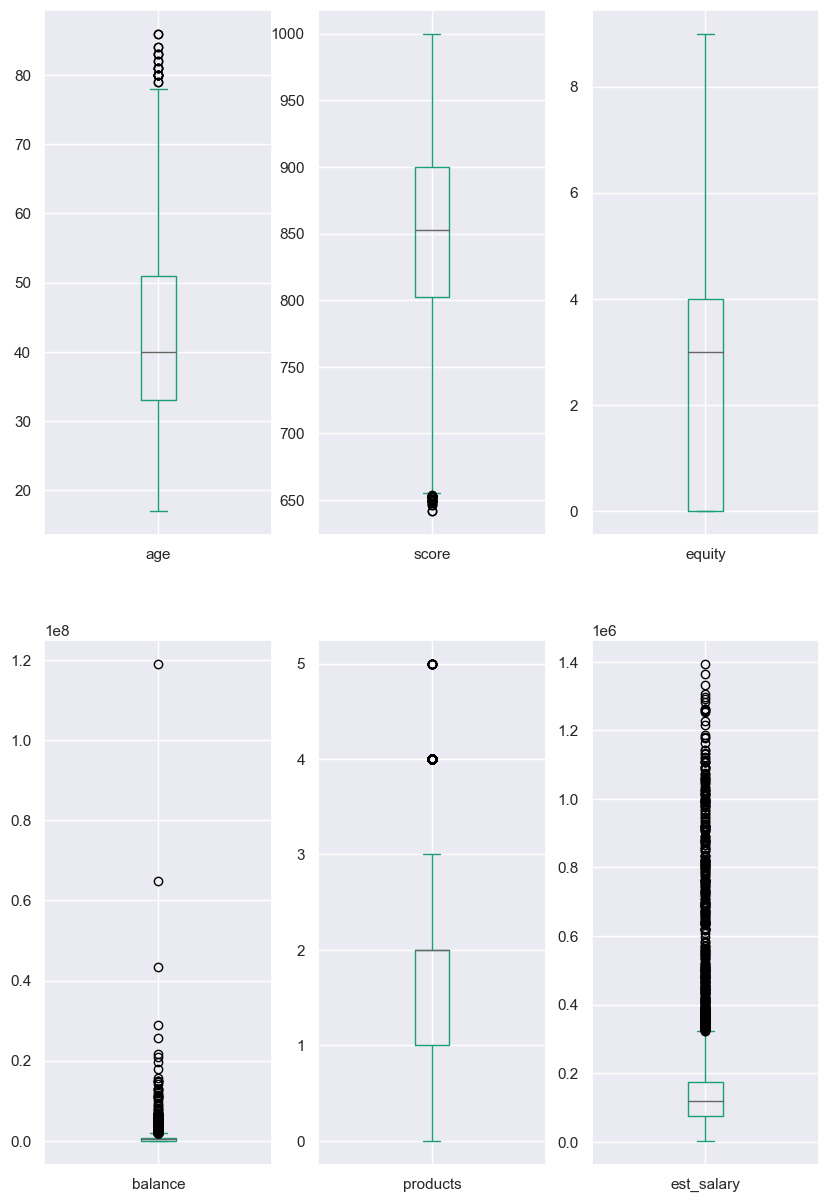

In [346]:
# построим графики распределения boxplot для числовых столбцов
data[num_cols].plot(
    kind='box',
    subplots=True,
    layout=(2, 3), 
    sharex=False,
    sharey=False,
    figsize=(10,15),
    colormap="Dark2"
);

(0.0, 2100000.0)

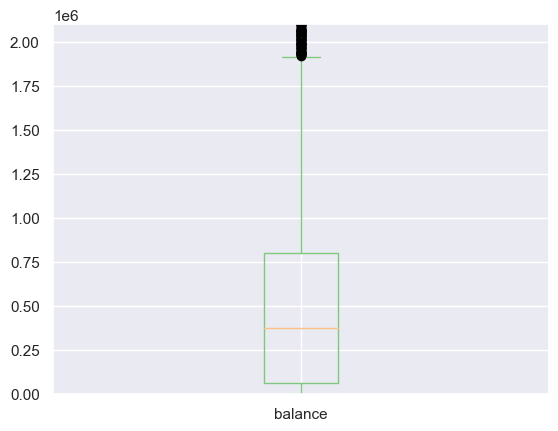

In [347]:
#для столбца баланс зададим ограничение по оси у
data['balance'].plot(kind='box')
plt.ylim(0, 2100000)


**Наблюдаем следующие значения выбросов: возраст старше 77 лет, баланс больше 2млн руб., заработная плата больше 300 тыс руб.**

In [348]:
print('Выбросов по возрасту:', data[data['age']>77]['user_id'].count())
print('Выбросов по балансу:', data[data['est_salary']>250000]['user_id'].count())
print('Выбросов по зп:', data[data['balance']>2000000]['user_id'].count())
print('Итого выбросов:', data[data['age']>77]['user_id'].count() + data[data['est_salary']>250000]['user_id'].count()\
      + data[data['balance']>2000000]['user_id'].count())

Выбросов по возрасту: 28
Выбросов по балансу: 901
Выбросов по зп: 428
Итого выбросов: 1357


**Если удалим выбросы, то лишимся 13% датасета. Если учесть, что еще у 23% датасета нет данных по балансу, то это будет некорректно. Следовательно, нужно найти оптимальное решение: чтобы выбросы не искажали результат, а также, чтобы удалить не более 10% данных.** 

In [349]:
#примем за выбросы баланс более 3 млн руб, з/п более 300 тыс руб и возраст старше 77 лет 
print(data[data['balance']>3000000]['user_id'].count())
print(data[data['est_salary']>300000]['user_id'].count())

201
565


In [350]:
#создадим переменную data_clean без выбросов
data_clean = data.query('age<77 and balance<3000000 and est_salary<300000')
data_clean.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0
2,120722,892,Рыбинск,Ж,30,0,100.00,1,1,1,107683.34,0
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,1


In [351]:
#число пользователей в очищенном датасете
total_users = len(data_clean)

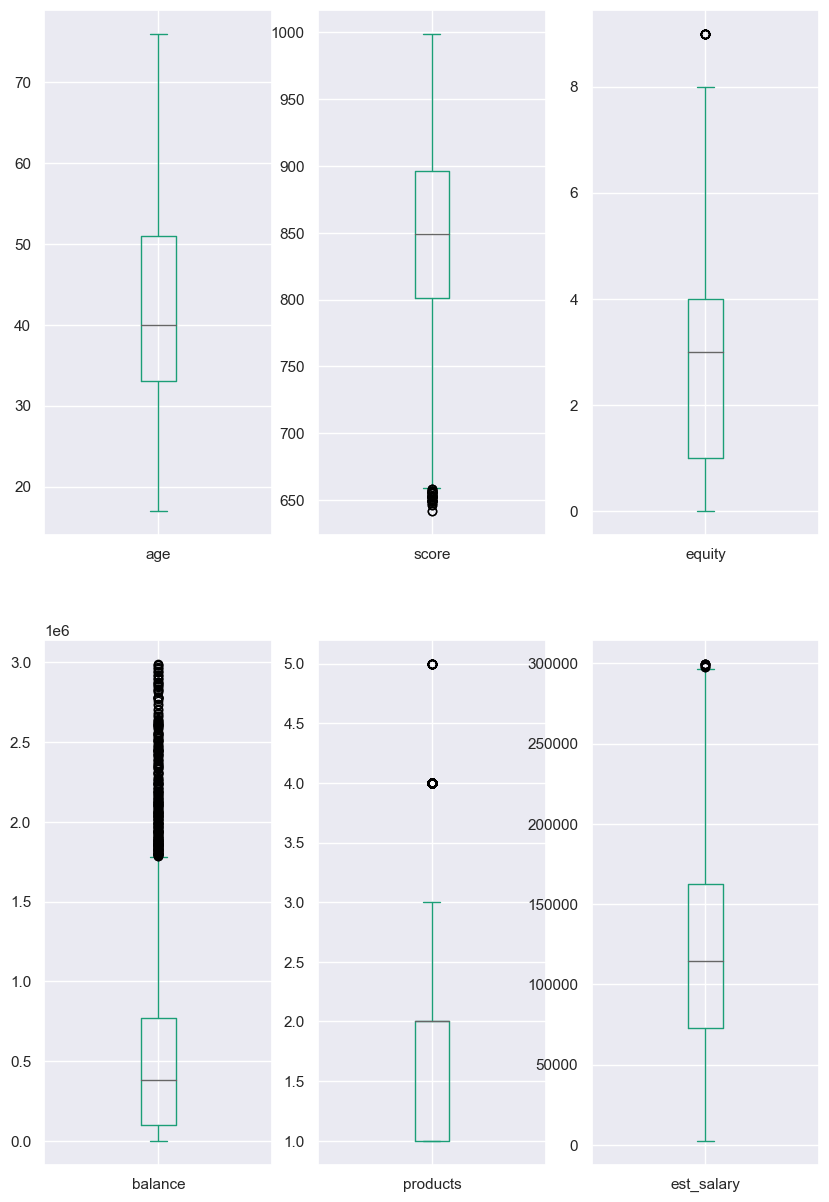

In [352]:
# построим графики распределения boxplot для числовых столбцов
data_clean[num_cols].plot(
    kind='box',
    subplots=True,
    layout=(2, 3), 
    sharex=False,
    sharey=False,
    figsize=(10,15),
    colormap="Dark2"
);

**Видим, что выбросов осталось значительно меньше.**

### Работа с аномалиями в данных

In [353]:
data_zero_prod=data[data['products']==0]
print(data_zero_prod)

#удалим таких клиентов
data_clean=data_clean.query('products!=0')

      user_id  score     city gender  age  equity  balance  products  \
8957   147837    962  Рыбинск      Ж   79       3    100.0         0   

      credit_card  last_activity  est_salary  churn  
8957            0              0    25063.96      1  


### Кодирование данных

Кодирование бинарными переменными методом pd.get_dummies

In [354]:
dum = pd.get_dummies(data_clean[['city', 'gender']])
data_clean_dum = pd.concat([data_clean, dum], axis=1)
data_clean_dum

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_Ростов,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0
2,120722,892,Рыбинск,Ж,30,0,100.00,1,1,1,107683.34,0,0,1,0,1,0
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553,814,Рыбинск,М,27,1,78144.65,1,0,1,18943.64,0,0,1,0,0,1
9996,139170,894,Ярославль,М,46,0,100.00,1,1,0,196898.29,0,0,0,1,0,1
9997,115639,903,Ярославль,М,24,0,100.00,2,1,1,108905.09,0,0,0,1,0,1
9998,148700,777,Ярославль,Ж,68,3,865457.97,3,0,1,86874.90,0,0,0,1,1,0


### Выводы по предобработке данных

Выполнена предобработка данных:

- переименованы колонки (названия приведены к нижнему змеиному регистру)
- изменены типы данных для экономия места на диске
- выполнена проверка на дубликаты, полных строк-дубликатов не обнаружено, обнаружены дубликаты в столбце user_id, но данные id пользователей принадлежат клиентам в разных городах, следовательно, удалять их не требуется
- обнаружены пропуски в столбце age и balance, которые были заполнены маркерными заглушками.
- обнаружены выбросы в столбцах age, balance, est_salary. От всех выбросов избавиться не сможем, т.к. потеряем слишком много данных, следовательно, нужно искать компромисс. При комбинации data_clean = data.query('age<77 and balance<3000000 and est_salary<300000'), удалится только 7% датасета, на этом и остановимся. 
- выполнена кодировка категориальных характеристик с помощью метода pd.dummies 
- удалены аномалии в данных

<a id='analysis'></a>
## Исследовательский анализ данных

In [355]:
#переименуем для удобства значения в столбце 
data_clean['churn']= data_clean['churn'].replace(0, "no")
data_clean['churn']= data_clean['churn'].replace(1, "yes")

In [356]:
#отфильтруем ушедших клиентов
data_churn=data_clean.query('churn=="yes"')

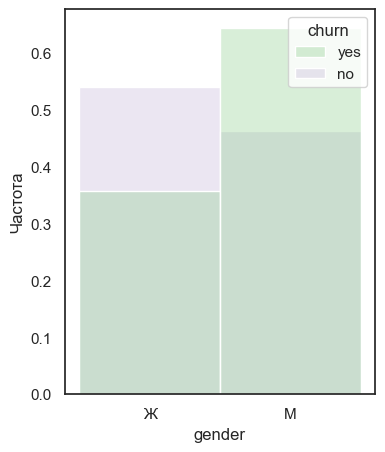

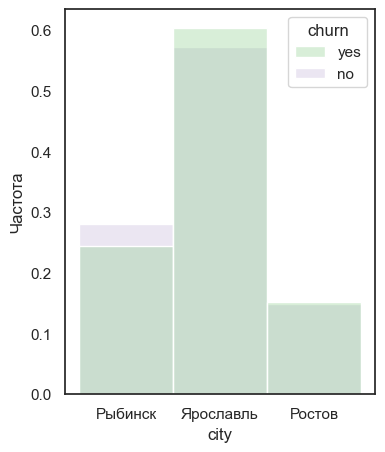

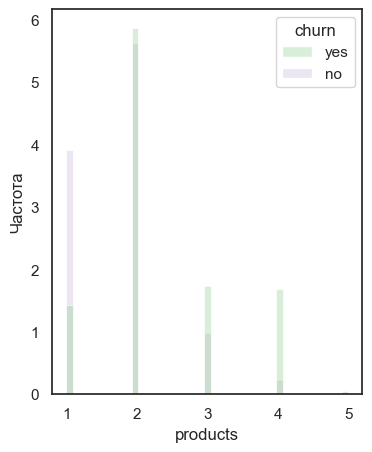

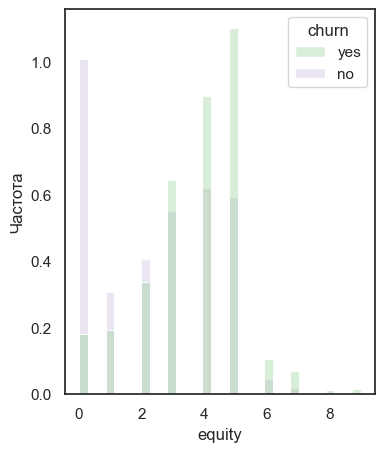

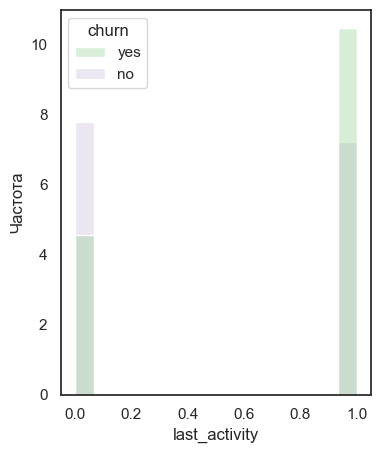

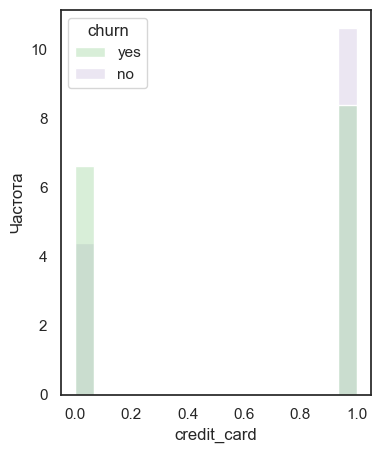

In [357]:
#создадим список характеристик, значения которых нам изначально даны в датасете (не нужно категоризировать) 
chars=['gender', 'city', 'products', 'equity', 'last_activity', 'credit_card']

#напишем цикл для перебора характеристик и построения столбчатых гистограмм ушедших и оставшихся клиентов
for char in chars:
    sns.set_style('white')
    plt.figure(figsize=(4, 5))
    sns.histplot(data=data_clean, x=data_clean[char], stat="density", common_norm=False, hue='churn', alpha=0.3)
   
    plt.ylabel('Частота')
    plt.show()

По столбчатым диаграммам характеристик, которые были изначально даны в датасете **(пол, город, количество продуктов, балл собственности, активность, наличие кредитной карты)** можно сделать предварительный вывод: больший уровень оттока показывают:

- мужчины
- клиенты из Ярославля
- клиенты с количеством продуктов >1
- клиенты с высоким баллом собственности
- активные клиенты
- клиенты, у которых есть кредитная карта

Другие признаки (скоринг, возраст, баланс, уровень дохода) нужно категоризировать, что будет сделано далее. 

### Категоризация данных

#### Определить значимые признаки отточности (интервалы значений характеристик, которые связаны с повышенным оттоком). Построить распределения (гистограммы) численных характеристик (возраст, доход, баланс, количество продуктов и т.д.)

In [358]:
#переименуем для удобства значения в столбце 
data_clean['churn']= data_clean['churn'].replace(0, "no")
data_clean['churn']= data_clean['churn'].replace(1, "yes")

In [359]:
#отфильтруем ушедших клиентов
data_churn=data_clean.query('churn=="yes"')

In [360]:
print('Кол-во клиентов', len(data_clean))
print('Кол-во ушедших клиентов', len(data_churn))
print('% оттока по очищенным данным', round( len(data_churn)/len(data_clean),2)*100)

Кол-во клиентов 9308
Кол-во ушедших клиентов 1678
% оттока по очищенным данным 18.0


##### Распределение баллов кредитного скоринга

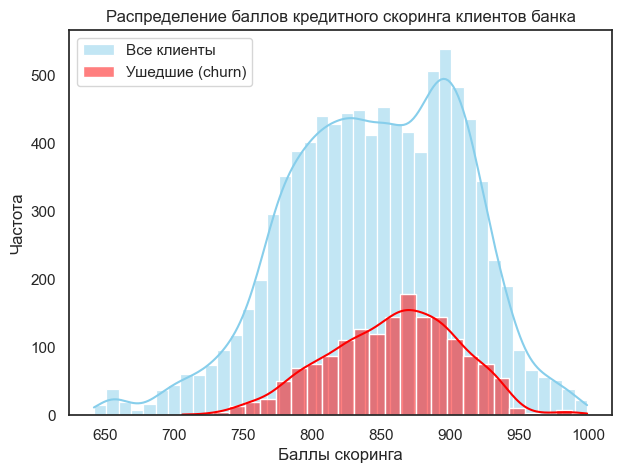

In [361]:
#построим на одном графике две гистограммы для всех клиентов (голубая) и для ушедших (красная)
plt.figure(figsize=(7, 5))
sns.histplot(data=data_clean, x=data_clean['score'], color="skyblue", label="Все клиенты", kde=True)
sns.histplot(data=data_churn, x=data_churn['score'], color="red", label="Ушедшие (churn)", kde=True)

plt.legend() 
plt.title('Распределение баллов кредитного скоринга клиентов банка')
plt.xlabel('Баллы скоринга')
plt.ylabel('Частота')
plt.show()

**По гистограмме видим, что клиенты разбиваются на несколько категорий несколько категорий. Чаще всего уходят клиенты с высоким баллом кредитного скоринга: 850-900.**

**На на основании гистограммы в датафрейме `data_clean` создадим столбец `score_cat` с категориями:**

- 0-820 — `'0-820'`;
- 821-920 — `'821-920'`;
- 921-1000 — `'921-1000'`.

In [362]:
#создадим ф-ю категоризации скоринга
def categorize_score(score):
    try:
        if 0 <= score <=820:
            return '0-820'
        elif 821 <= score <= 920:
            return '821-920'
        elif 921 <= score <= 1000:
            return '921-1000'
        
    except:
        pass

In [363]:
data_clean['score_cat'] = data_clean['score'].apply(categorize_score)
data_clean.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,score_cat
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,yes,821-920
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,no,821-920
2,120722,892,Рыбинск,Ж,30,0,100.00,1,1,1,107683.34,no,821-920
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,yes,821-920
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,yes,0-820


##### Распределение возраста клиентов

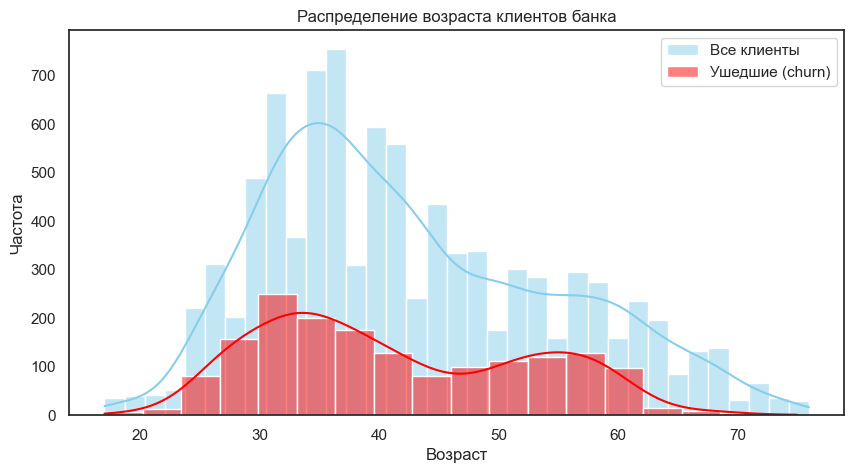

In [364]:
#построим на одном графике две гистограммы для всех клиентов (голубая) и для ушедших (красная)
plt.figure(figsize=(10, 5))
sns.histplot(data=data_clean, x=data_clean['age'], color="skyblue", label="Все клиенты", kde=True)
sns.histplot(data=data_churn, x=data_churn['age'], color="red", label="Ушедшие (churn)", kde=True)

plt.legend() 
plt.title('Распределение возраста клиентов банка')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

**Наглядно видно, что контуры распределения всех клиентов и ушедших очень похожи (количество ушедших прямопропорционально количеству всех клиентов). Однако, можно наблюдать, что чаще всего уходят клиенты в возрасте 18-40 лет и 50-60 лет.**

**На на основании гистограммы в датафрейме `data_clean` создадим столбец `age_category` с категориями:**

- 18-40 — `'18-40'`;
- 41-49 — `'41_49'`;
- 50-60 — `'50_60'`;
- 61+  — `'61'`.

In [365]:
#создадим ф-ю категоризации возраста
def categorize_age(age):
    try:
        if 18 <= age <= 40:
            return '18_40'
        elif 41 <= age <= 49:
            return '41_49'
        elif 50 <= age <= 60:
            return '50_60'
        elif age <= 61:
            return '61_77'
    except:
        pass

In [366]:
data_clean['age_cat'] = data_clean['age'].apply(categorize_age)
data_clean.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,score_cat,age_cat
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,yes,821-920,18_40
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,no,821-920,18_40
2,120722,892,Рыбинск,Ж,30,0,100.00,1,1,1,107683.34,no,821-920,18_40
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,yes,821-920,50_60
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,yes,0-820,18_40


**Самый высокий процент оттока у категории у категории 18-40 и 50-60 лет, причем, судя по гистограмме, пользователей такого возраста больше всего в датасете. Также высокий отток у категории 50-60 лет**

##### Распределение баланса на счете клиентов

In [367]:
#посмотрим сколько клиентов с нулевым балансом. 
#их всего два
data_clean[data_clean['balance']==0]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,score_cat,age_cat
3900,179831,730,Ярославль,М,18,0,0.0,2,1,1,64548.33,no,0-820,18_40
6757,148456,813,Ярославль,М,20,2,0.0,2,1,0,23876.51,no,0-820,18_40


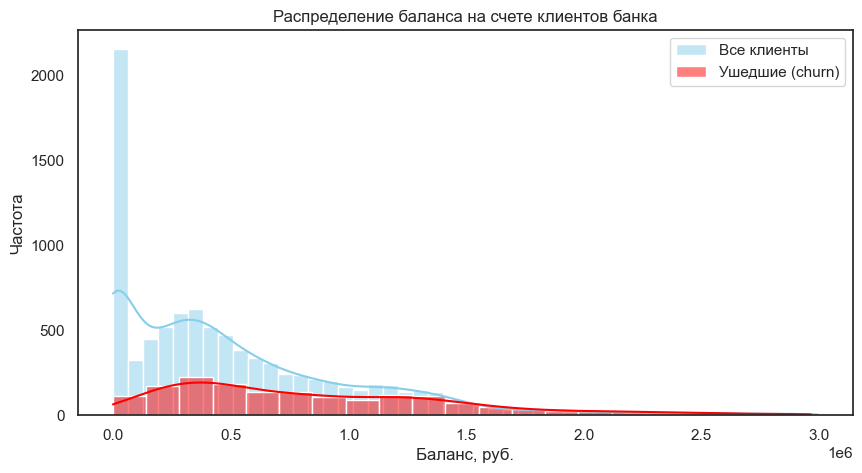

In [368]:
#построим на одном графике две гистограммы для всех клиентов (голубая) и для ушедших (красная)
plt.figure(figsize=(10, 5))
sns.histplot(data=data_clean, x=data_clean['balance'], color="skyblue", label="Все клиенты", kde=True)
sns.histplot(data=data_churn, x=data_churn['balance'], color="red", label="Ушедшие (churn)", kde=True)

plt.legend() 
plt.title('Распределение баланса на счете клиентов банка')
plt.xlabel('Баланс, руб.')
plt.ylabel('Частота')
plt.show()

**На гистограмме ВСЕ КЛИЕНТЫ видим большой пик клиентов с балансом 100 (маркерная заглушка).  При этом соответствующего пика УШЕДШИХ не наблюдаем.**

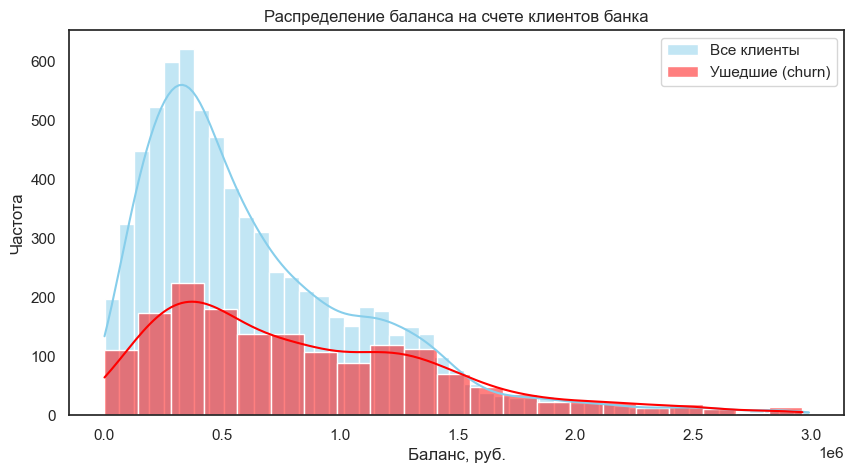

In [369]:
#уберем клиентов с нулевым балансом и балансом заглушки
data_clean1=data_clean.query('balance > 100')

plt.figure(figsize=(10, 5))
sns.histplot(data=data_clean1, x=data_clean1['balance'], color="skyblue", label="Все клиенты", kde=True)
sns.histplot(data=data_churn, x=data_churn['balance'], color="red", label="Ушедшие (churn)", kde=True)

plt.legend() 
plt.title('Распределение баланса на счете клиентов банка')
plt.xlabel('Баланс, руб.')
plt.ylabel('Частота')
plt.show()

**Как и в случае с распределением возраста видим, что контуры распределения всех клиентов и ушедших очень похожи (количество ушедших прямопропорционально количеству всех клиентов). Тем не менее более склонны уходить клиенты с балансом от 200 до 600 тыс. и (!) от 1.2 до 3 млн. КЛИЕНТЫ С БОЛЬШИМИ СУММАМИ НА СЧЕТУ (ОТ 1.2 МЛН РУБ.) СКЛОННЫ ПОКИДАТЬ БАНК!**

In [370]:
#создадим ф-ю категоризации баланса
def categorize_balance(balance):
    try:
        if 100 <= balance <= 200000:
            return 'small'
        elif 200001 <= balance <= 1200000:
            return 'middle'        
        elif 1200001 <= balance:
            return 'big'              
    except:
        pass

In [371]:
data_clean['balance_cat'] = data_clean['balance'].apply(categorize_balance)
data_clean.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,score_cat,age_cat,balance_cat
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,yes,821-920,18_40,small
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,no,821-920,18_40,middle
2,120722,892,Рыбинск,Ж,30,0,100.00,1,1,1,107683.34,no,821-920,18_40,small
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,yes,821-920,50_60,big
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,yes,0-820,18_40,small


##### Распределение доходов клиентов

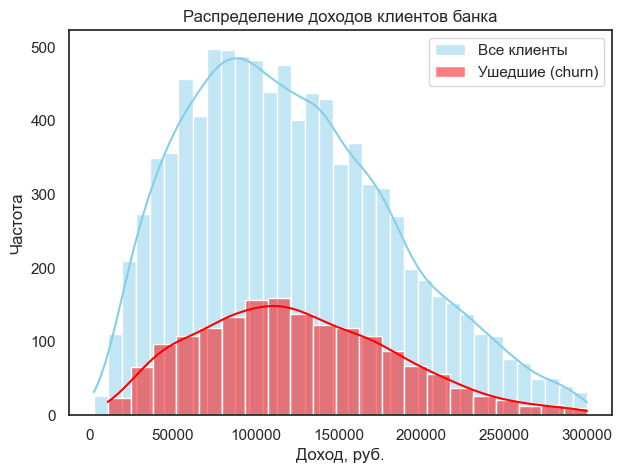

In [372]:
#построим на одном графике две гистограммы для всех клиентов (голубая) и для ушедших (красная)
plt.figure(figsize=(7, 5))
sns.histplot(data=data_clean, x=data_clean['est_salary'], color="skyblue", label="Все клиенты", kde=True)
sns.histplot(data=data_churn, x=data_churn['est_salary'], color="red", label="Ушедшие (churn)", kde=True)

plt.legend() 
plt.title('Распределение доходов клиентов банка')
plt.xlabel('Доход, руб.')
plt.ylabel('Частота')
plt.show()

**В очередной раз отметим, что контуры распределения всех клиентов и ушедших очень похожи (количество ушедших прямопропорционально количеству всех клиентов). Тем не менее более склонны уходить клиенты с доходом от 70 до 170 тыс.**

In [373]:
#создадим ф-ю категоризации возраста
def categorize_salary(est_salary):
    try:
        if 0 <= est_salary <= 70000:
            return 'low'
        elif 70001 <= est_salary <= 170000:
            return 'middle'
        elif 170001 <= est_salary:
            return 'high'              
    except:
        pass

In [374]:
data_clean['salary_cat'] = data_clean['est_salary'].apply(categorize_salary)
data_clean.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,score_cat,age_cat,balance_cat,salary_cat
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,yes,821-920,18_40,small,middle
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,no,821-920,18_40,middle,middle
2,120722,892,Рыбинск,Ж,30,0,100.00,1,1,1,107683.34,no,821-920,18_40,small,middle
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,yes,821-920,50_60,big,high
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,yes,0-820,18_40,small,low


#### Расчет доли ушедших пользователей

**Для того, чтобы объективно оценить долю ушедших пользователей в категории, на мой взгляд, следует разделить количество пользователей в категории на число всех ушедших пользователей (которых у нас 1678).**

In [402]:
#создадим список категорий, которые будем перебирать в цикле для построения сводной таблицы
chars = ['city', 'gender', 'products', 'equity', 'credit_card', 'last_activity', 'age_cat','salary_cat', 'balance_cat', 'score_cat']

for char in chars:
    data_char_agg = data_clean.pivot_table(index=char, values='user_id', columns='churn',\
                                          aggfunc='count').reset_index()
    #создадим столбец 'cat_all', который вычислит сумму всех пользователей в категории
    data_char_agg['cat_all']=data_char_agg['no']+data_char_agg['yes']
    #создадим столбец, который вычислит процент ушедших по категории
    data_char_agg['cat_churn_part']=data_char_agg['yes']/data_char_agg['cat_all']*100
    #создадим столбец, который вычислит процент ушедших пользователей в категории от всех ушедших пользователей в data_churn
    data_char_agg['total_churn_part']=round(data_char_agg['yes']/len(data_churn)*100, 2)
    #отсортируем в порядке убывания доли ушедших пользователей 
    display(data_char_agg.sort_values(by='total_churn_part', ascending=False))
    
    labels=data_char_agg[char]
    values=data_char_agg['total_churn_part']
    fig = px.pie(data_char_agg, values=values, names=labels, color_discrete_sequence=px.colors.qualitative.Set3)
    fig.update_layout(width=400, # указываем размеры графика
                  height=400)
    fig.show()

churn,city,no,yes,cat_all,cat_churn_part,total_churn_part
2,Ярославль,4365,1013,5378,18.835999,60.37
1,Рыбинск,2137,409,2546,16.064415,24.37
0,Ростов,1128,256,1384,18.497110,15.26


churn,gender,no,yes,cat_all,cat_churn_part,total_churn_part
1,М,3520,1080,4600,23.478261,64.36
0,Ж,4110,598,4708,12.701784,35.64


churn,products,no,yes,cat_all,cat_churn_part,total_churn_part
1,2,3985,916,4901,18.690063,54.59
2,3,700,270,970,27.835052,16.09
3,4,161,262,423,61.938534,15.61
0,1,2773,222,2995,7.412354,13.23
4,5,11,8,19,42.105263,0.48


churn,equity,no,yes,cat_all,cat_churn_part,total_churn_part
5,5,1269,520,1789,29.066518,30.99
4,4,1329,423,1752,24.143836,25.21
3,3,1184,304,1488,20.430108,18.12
2,2,870,159,1029,15.451895,9.48
1,1,657,91,748,12.165775,5.42
0,0,2163,85,2248,3.781139,5.07
6,6,99,50,149,33.557047,2.98
7,7,43,33,76,43.421053,1.97
9,9,6,7,13,53.846154,0.42
8,8,10,6,16,37.500000,0.36


churn,credit_card,no,yes,cat_all,cat_churn_part,total_churn_part
1,1,5392,938,6330,14.818325,55.9
0,0,2238,740,2978,24.848892,44.1


churn,last_activity,no,yes,cat_all,cat_churn_part,total_churn_part
1,1,3667,1169,4836,24.172870,69.67
0,0,3963,509,4472,11.381932,30.33


churn,age_cat,no,yes,cat_all,cat_churn_part,total_churn_part
0,18_40,3851,923,4774,19.333892,55.01
2,50_60,1222,429,1651,25.984252,25.57
1,41_49,1643,266,1909,13.933997,15.85
3,61_77,148,16,164,9.756098,0.95


churn,salary_cat,no,yes,cat_all,cat_churn_part,total_churn_part
2,middle,4143,978,5121,19.097832,58.28
0,high,1648,380,2028,18.737673,22.65
1,low,1839,320,2159,14.821677,19.07


churn,balance_cat,no,yes,cat_all,cat_churn_part,total_churn_part
1,middle,4175,1055,5230,20.172084,62.87
0,big,626,447,1073,41.658900,26.64
2,small,2808,174,2982,5.835010,10.37


churn,score_cat,no,yes,cat_all,cat_churn_part,total_churn_part
1,821-920,3885,1157,5042,22.947243,68.95
0,0-820,2886,363,3249,11.172669,21.63
2,921-1000,859,158,1017,15.535890,9.42


По построенным круговым диаграммам видно, что самый высокий процент ушедших пользователей в категории от всех ушедших пользователей: 
- в Ярославле (60.4%)
- у мужчин (64.4%)
- у клиентов, имеющих 2 продукта (54.6%)
- с баллом собственности 5, 4 и 3
- имеющими кредитную карты (56%)
- которые были активны (70%)
- в возрастной категории 18-40 лет (56.5%) и 50-60 лет (26.3%)
- со средними доходами (70-170 тыс.руб) (58.3%)
- со средним балансом (200-600 тыс. руб) – 63% и высоким балансом (от 1.2 млн.руб) – 27%
- баллом скоринга 820-920 (70%)

### Корреляция данных

Построить матрицу корреляции и другие визуализации с целью выявление признаков, которые влияют на отток клиентов.

In [376]:
#удалим из датасета ненужные колонки
data_corr = data_clean_dum.query('churn==1').drop(['user_id', 'city',  'gender', 'churn'], axis=1)
data_corr

,score,age,equity,balance,products,credit_card,last_activity,est_salary,city_Ростов,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
0,850,25,1,59214.82,2,0,1,75719.14,0,1,0,1,0
3,866,51,5,1524746.26,2,0,1,174423.53,0,0,1,1,0
4,730,34,5,174.00,1,1,0,67353.16,0,0,1,0,1
12,845,31,3,591928.52,2,1,1,112697.16,0,0,1,1,0
40,811,34,2,129799.35,1,0,0,96242.71,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9981,892,39,5,636287.72,2,0,1,227288.27,0,1,0,0,1
9986,822,58,5,1434857.91,2,0,1,83442.41,0,0,1,0,1
9987,783,61,3,387916.16,2,1,0,63160.96,0,1,0,1,0
9992,813,48,2,179765.62,2,1,0,133972.11,0,1,0,0,1


<Axes: >

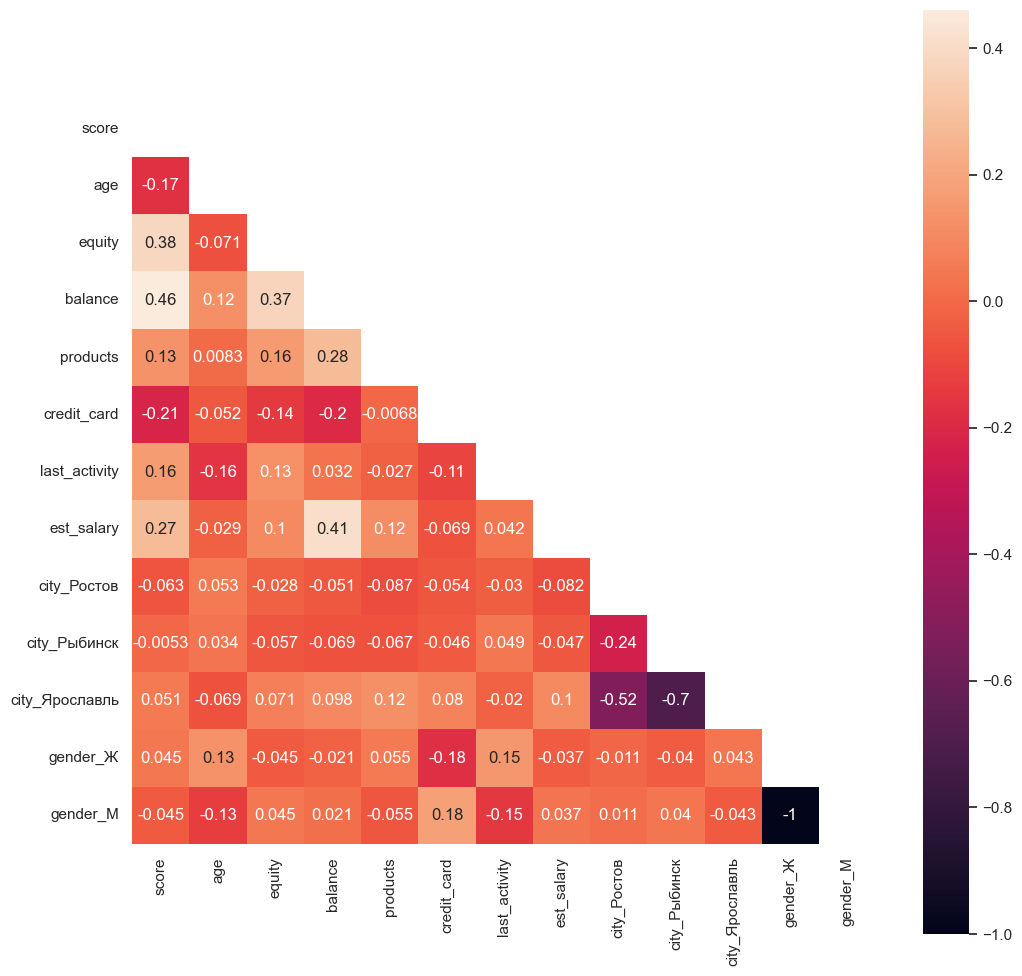

In [377]:
# построим хитмап для корреляций числовых признаков
plt.figure(figsize=(12,12))

# вычислим корреляцию между каждой парой переменных
corr_matrix=data_corr.corr()
 
# оставим только половину матрицы
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_matrix, mask=mask, square=True, annot=True)

*К сожалению, мне не очень понятно, каким образом участвуют столбцы dummies в корреляции. Напр, gender_Ж и gender_M отличаются знаком, какой вывод их этого нужно сделать, мне не ясно...*

<Axes: >

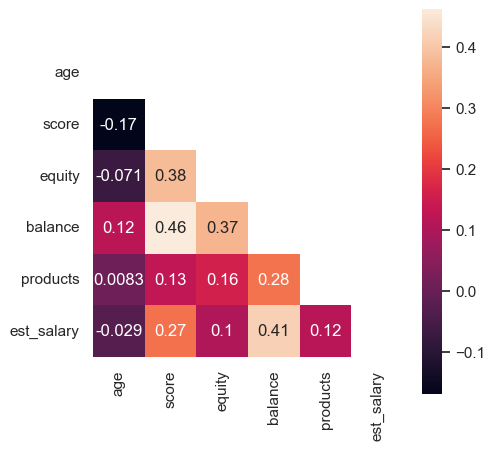

In [378]:
# построим хитмап для корреляций числовых признаков
plt.figure(figsize=(5,5))

# вычислим корреляцию между каждой парой переменных
corr_matrix=data_corr[num_cols].corr()
 
# оставим только половину матрицы
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_matrix, mask=mask, square=True, annot=True)

**По корреляции числовых колонок можно сделать вывод, что банковский скоринг тем выше, чем выше доход, балл собственности и баланс. Также, чем больше возраст и доход и количество продуктов, тем выше баланс.**

### Портреты типичных клиентов, которые склонны и не склонны уходить из банка

Выделить портреты пользователей с 2-3 признаками, например, "Мужчины из Ярославля старше 40 лет", "Женщины из Ростова с количеством продуктов банка больше двух"...

#### Портреты типичных клиентов, которые склонны уходить из банка

**Поиграем с комбинациями нескольких признаков, выделенных в п. 5.1.2 Доли ушедших пользователей. Особенно полезны те признаки, доли которых 60-70%**

#####  Признаки: категория баланса и возраст 

In [379]:
data_cat_agg = data_clean.pivot_table(index=['age_cat', 'balance_cat'], values='user_id', columns='churn', aggfunc='count').reset_index()

    #создадим столбец 'cat_all', который вычислит сумму всех пользователей в категории
data_cat_agg['cat_all']=data_cat_agg['no']+data_cat_agg['yes']
    #создадим столбец, который вычислит процент ушедших по категории
data_cat_agg['cat_churn_part']=round(data_cat_agg['yes']/data_cat_agg['cat_all']*100,2)
    #создадим столбец, который вычислит процент ушедших пользователей в категории от всех ушедших пользователей в data_churn
data_cat_agg['churn_churn_part']=round(data_cat_agg['yes']/len(data_churn)*100, 2)
    #создадим столбец, который вычислит процент ушедших пользователей в категории от всех пользователей в data_clean
data_cat_agg['all_churn_part']=round(data_cat_agg['yes']/len(data_clean)*100, 2)
    #отсортируем в порядке убывания доли ушедших пользователей
display(data_cat_agg.sort_values(by='churn_churn_part', ascending=False).head(5))

churn,age_cat,balance_cat,no,yes,cat_all,cat_churn_part,churn_churn_part,all_churn_part
1,18_40,middle,1985,584,2569,22.73,34.80,6.27
7,50_60,middle,694,272,966,28.16,16.21,2.92
0,18_40,big,211,222,433,51.27,13.23,2.39
4,41_49,middle,945,158,1103,14.32,9.42,1.70
6,50_60,big,128,137,265,51.70,8.16,1.47


**В первых трех строчках, а также в 5ой заключены самые отточные категории клиентов. Это клиенты со средним и высоким балансом в категориях 18-40 и 50-60 лет. Особенно важно обратить внимание на то, что клиенты с большим балансом (>1.2 млн) уходят в 50% случаев!**

In [380]:
print('Количество клиентов 18-40 и 50-60 лет со средним или высоким балансом:', len(data_clean.query\
    ('churn=="yes" and (age_cat=="18_40" or age_cat=="50_60") and (salary_cat =="middle" or salary_cat =="high")')))
print('Доля таких клиентов от всех ушедших пользователей:', round(len(data_clean.query\
    ('churn=="yes" and (age_cat=="18_40" or age_cat=="50_60") and (salary_cat =="middle" or salary_cat =="high")'))/\
len(data_churn)*100,2), '%')
print('Доля таких клиентов от всех пользователей:', round(len(data_clean.query\
    ('churn=="yes" and (age_cat=="18_40" or age_cat=="50_60") and (salary_cat =="middle" or salary_cat =="high")'))/\
len(data_clean)*100,2), '%')

Количество клиентов 18-40 и 50-60 лет со средним или высоким балансом: 1075
Доля таких клиентов от всех ушедших пользователей: 64.06 %
Доля таких клиентов от всех пользователей: 11.55 %


**Выделим отдельно категории 18-40 лет и 50-60 лет:**

In [381]:
segm_1 = len(data_clean.query\
    ('churn=="yes" and age_cat=="18_40" and (balance_cat =="middle" or balance_cat =="big")'))

print('Количество клиентов 18-40 лет со средним и высоким балансом:', segm_1)
print('Доля таких клиентов от всех ушедших пользователей:', round(len(data_clean.query\
    ('churn=="yes" and age_cat=="18_40" and (balance_cat =="middle" or balance_cat =="big")'))/\
len(data_churn)*100,2), '%')
print('Доля таких клиентов от всех пользователей:', round(len(data_clean.query\
    ('churn=="yes" and age_cat=="18_40" and (balance_cat =="middle" or balance_cat =="big")'))/\
len(data_clean)*100,2), '%')
print("-----")
segm_2 = len(data_clean.query\
    ('churn=="yes" and age_cat=="50_60" and (balance_cat =="middle" or balance_cat =="big")'))
print('Количество клиентов 50-60 лет со средним и высоким балансом:', segm_2)
print('Доля таких клиентов от всех ушедших пользователей:', round(len(data_clean.query\
    ('churn=="yes" and age_cat=="50_60" and (balance_cat =="middle" or balance_cat =="big")'))/\
len(data_churn)*100,2), '%')
print('Доля таких клиентов от всех пользователей:', round(len(data_clean.query\
    ('churn=="yes" and age_cat=="50_60" and (balance_cat =="middle" or balance_cat =="big")'))/\
len(data_clean)*100,2), '%')

Количество клиентов 18-40 лет со средним и высоким балансом: 806
Доля таких клиентов от всех ушедших пользователей: 48.03 %
Доля таких клиентов от всех пользователей: 8.66 %
-----
Количество клиентов 50-60 лет со средним и высоким балансом: 409
Доля таких клиентов от всех ушедших пользователей: 24.37 %
Доля таких клиентов от всех пользователей: 4.39 %


#####  Признаки: категория баланса, возраст и город (к предыдущей категории добавим признак города)

In [382]:
#сделаем уточнение пункта выше с городом
data_cat_agg = data_clean.pivot_table(index=['balance_cat', 'age_cat', 'city'], values='user_id', columns='churn', aggfunc='count').reset_index()

    #создадим столбец 'cat_all', который вычислит сумму всех пользователей в категории
data_cat_agg['cat_all']=data_cat_agg['no']+data_cat_agg['yes']
    #создадим столбец, который вычислит процент ушедших по категории
data_cat_agg['cat_churn_part']=round(data_cat_agg['yes']/data_cat_agg['cat_all']*100,2)
    #создадим столбец, который вычислит процент ушедших пользователей в категории от всех ушедших пользователей в data_churn
data_cat_agg['churn_churn_part']=round(data_cat_agg['yes']/len(data_churn)*100, 2)
    #создадим столбец, который вычислит процент ушедших пользователей в категории от всех пользователей в data_clean
data_cat_agg['all_churn_part']=round(data_cat_agg['yes']/len(data_clean)*100, 2)
    #отсортируем в порядке убывания доли ушедших пользователей
display(data_cat_agg.sort_values(by='churn_churn_part', ascending=False).head(5))

churn,balance_cat,age_cat,city,no,yes,cat_all,cat_churn_part,churn_churn_part,all_churn_part
14,middle,18_40,Ярославль,1141.0,371.0,1512.0,24.54,22.11,3.99
2,big,18_40,Ярославль,128.0,152.0,280.0,54.29,9.06,1.63
20,middle,50_60,Ярославль,356.0,144.0,500.0,28.80,8.58,1.55
13,middle,18_40,Рыбинск,555.0,129.0,684.0,18.86,7.69,1.39
17,middle,41_49,Ярославль,533.0,85.0,618.0,13.75,5.07,0.91


**Итак, видим, что у нас в топе клиенты 18-40 лет из Ярославля со средним и высоким балансом.**

При необходимости можно построить визуализации доли оттока от двух признаков

In [383]:
#построим столбчатую диаграмму на основании сводной таблицы для категорий баланса и возраста
fig = px.bar(data_cat_agg, 
             x='churn_churn_part', 
             y='balance_cat',
             text='churn_churn_part',
             color='age_cat',
             color_discrete_sequence=px.colors.qualitative.Set3)

fig.update_layout(title='Доля ушедших пользователей в зависимости от категории',
                   xaxis_title='Доля ушедших пользователей',
                   yaxis_title='Категория баланса',
                   yaxis={'categoryorder':'total ascending'},
                   width=700, # указываем размеры графика
                   height=400)
#fig.show()

In [384]:
#построим столбчатую диаграмму на основании сводной таблицы для категорий баланса и города
fig = px.bar(data_cat_agg, 
             x='churn_churn_part', 
             y='balance_cat',
             text='churn_churn_part',
             color='city',
             color_discrete_sequence=px.colors.qualitative.Set3)

fig.update_layout(title='Доля ушедших пользователей в зависимости от категории',
                   xaxis_title='Доля ушедших пользователей',
                   yaxis_title='Категория баланса',
                   yaxis={'categoryorder':'total ascending'},
                   width=700, # указываем размеры графика
                   height=400)
#fig.show()

In [385]:
segm_3 = len(data_clean.query\
    ('churn=="yes" and age_cat=="18_40" and (balance_cat =="middle" or balance_cat =="big") and city == "Ярославль"'))

print('Количество клиентов 18-40 лет из Ярославля со средним и высоким балансом:', segm_3)
print('Доля таких клиентов от всех ушедших пользователей:', round(len(data_clean.query\
    ('churn=="yes" and age_cat=="18_40" and (balance_cat =="middle" or balance_cat =="big") and city == "Ярославль"'))/\
len(data_churn)*100,2), '%')
print('Доля таких клиентов от всех пользователей:', round(len(data_clean.query\
    ('churn=="yes" and age_cat=="18_40" and (balance_cat =="middle" or balance_cat =="big") and city == "Ярославль"'))/\
len(data_clean)*100,2), '%')

Количество клиентов 18-40 лет из Ярославля со средним и высоким балансом: 523
Доля таких клиентов от всех ушедших пользователей: 31.17 %
Доля таких клиентов от всех пользователей: 5.62 %


#####  Признаки: категория дохода и возраста

In [386]:
data_salary_cat_agg = data_clean.pivot_table(index=['salary_cat', 'age_cat'], values='user_id', columns='churn', aggfunc='count').reset_index()

    #создадим столбец 'cat_all', который вычислит сумму всех пользователей в категории
data_salary_cat_agg['cat_all']=data_salary_cat_agg['no']+data_salary_cat_agg['yes']
    #создадим столбец, который вычислит процент ушедших по категории
data_salary_cat_agg['cat_churn_part']=round(data_salary_cat_agg['yes']/data_salary_cat_agg['cat_all']*100,2)
    #создадим столбец, который вычислит процент ушедших пользователей в категории от всех ушедших пользователей в data_churn
data_salary_cat_agg['churn_churn_part']=round(data_salary_cat_agg['yes']/len(data_churn)*100, 2)
    #создадим столбец, который вычислит процент ушедших пользователей в категории от всех пользователей в data_clean
data_salary_cat_agg['all_churn_part']=round(data_salary_cat_agg['yes']/len(data_clean)*100, 2)
    #отсортируем в порядке убывания доли ушедших пользователей
display(data_salary_cat_agg.sort_values(by='churn_churn_part', ascending=False).head())

churn,salary_cat,age_cat,no,yes,cat_all,cat_churn_part,churn_churn_part,all_churn_part
8,middle,18_40,2076,544,2620,20.76,32.42,5.84
10,middle,50_60,737,263,1000,26.30,15.67,2.83
0,high,18_40,805,215,1020,21.08,12.81,2.31
4,low,18_40,970,164,1134,14.46,9.77,1.76
9,middle,41_49,935,150,1085,13.82,8.94,1.61


**В верхних строчках датасета клиенты со средним доходом (70-170 тыс.руб.) 18-40 и 50-60 лет.**

In [387]:
segm_4 = len(data_clean.query\
    ('churn=="yes" and (age_cat=="18_40" or age_cat=="50_60") and salary_cat =="middle"'))

print('Количество клиентов 18-40 и 50-60 лет со средней зарплатой:', segm_4)
print('Доля таких клиентов от всех ушедших пользователей:', round(len(data_clean.query\
    ('churn=="yes" and (age_cat=="18_40" or age_cat=="50_60") and salary_cat =="middle"'))/\
len(data_churn)*100,2), '%')
print('Доля таких клиентов от всех пользователей:', round(len(data_clean.query\
    ('churn=="yes" and (age_cat=="18_40" or age_cat=="50_60") and salary_cat =="middle"'))/\
len(data_clean)*100,2), '%')

Количество клиентов 18-40 и 50-60 лет со средней зарплатой: 807
Доля таких клиентов от всех ушедших пользователей: 48.09 %
Доля таких клиентов от всех пользователей: 8.67 %


#####  Признаки: категория дохода, возраста и города

In [388]:
data_salary_cat_agg = data_clean.pivot_table(index=['salary_cat', 'age_cat', 'city'], values='user_id', columns='churn', aggfunc='count').reset_index()

    #создадим столбец 'cat_all', который вычислит сумму всех пользователей в категории
data_salary_cat_agg['cat_all']=data_salary_cat_agg['no']+data_salary_cat_agg['yes']
    #создадим столбец, который вычислит процент ушедших по категории
data_salary_cat_agg['cat_churn_part']=round(data_salary_cat_agg['yes']/data_salary_cat_agg['cat_all']*100,2)
    #создадим столбец, который вычислит процент ушедших пользователей в категории от всех ушедших пользователей в data_churn
data_salary_cat_agg['churn_churn_part']=round(data_salary_cat_agg['yes']/len(data_churn)*100, 2)
    #создадим столбец, который вычислит процент ушедших пользователей в категории от всех пользователей в data_clean
data_salary_cat_agg['all_churn_part']=round(data_salary_cat_agg['yes']/len(data_clean)*100, 2)
    #отсортируем в порядке убывания доли ушедших пользователей
display(data_salary_cat_agg.sort_values(by='churn_churn_part', ascending=False).head())

churn,salary_cat,age_cat,city,no,yes,cat_all,cat_churn_part,churn_churn_part,all_churn_part
26,middle,18_40,Ярославль,1193.0,345.0,1538.0,22.43,20.56,3.71
2,high,18_40,Ярославль,546.0,150.0,696.0,21.55,8.94,1.61
32,middle,50_60,Ярославль,373.0,144.0,517.0,27.85,8.58,1.55
25,middle,18_40,Рыбинск,590.0,122.0,712.0,17.13,7.27,1.31
14,low,18_40,Ярославль,553.0,92.0,645.0,14.26,5.48,0.99


**Первые места по оттоку принадлежат клиентам 18-40 лет со средними и высокими доходами из Ярославля**.

In [389]:
segm_5 = len(data_clean.query\
    ('churn=="yes" and age_cat=="18_40" and (salary_cat =="middle" or salary_cat =="high") and city == "Ярославль"'))

print('Количество клиентов 18-40 лет со средней или высокой зарплатой из Ярославля:', segm_5)
print('Доля таких клиентов от всех ушедших пользователей:', round(segm_5/len(data_churn)*100,2), '%')
print('Доля таких клиентов от всех пользователей:', round(segm_5/len(data_clean)*100,2), '%')

Количество клиентов 18-40 лет со средней или высокой зарплатой из Ярославля: 495
Доля таких клиентов от всех ушедших пользователей: 29.5 %
Доля таких клиентов от всех пользователей: 5.32 %


#### Портреты типичных клиентов, которые НЕ склонны уходить из банка

##### Не склонны уходить из банка клиенты c низким доходом или маленьким балансом

In [390]:
print('Количество клиентов с низким доходом или маленьким балансом:', len(data_clean.query\
    ('churn=="no" and (balance_cat=="small" or salary_cat=="low")')))
print('Доля таких клиентов от всех оставшихся пользователей:',\
      round(len(data_clean.query('churn=="no" and (balance_cat=="small" or salary_cat=="low")'))/\
            (len(data_clean)- len(data_churn))*100,2), '%')
print('Доля таких клиентов от всех пользователей:',\
      round(len(data_clean.query('churn=="no" and (balance_cat=="small" or salary_cat=="low")'))/\
            len(data_clean)*100,2), '%')

Количество клиентов с низким доходом или маленьким балансом: 4144
Доля таких клиентов от всех оставшихся пользователей: 54.31 %
Доля таких клиентов от всех пользователей: 44.52 %


##### Не склонны уходить из банка клиенты в возрасте 41-49 и 61-77 лет из Ростова и Рыбинска:

In [391]:
print('Количество клиентов 41-49 и 61-77 лет из Рыбинска и Ростова:', len(data_clean.query\
    ('churn=="no" and (age_cat=="41_49" or age_cat=="61_77") and city != "Ярославль"')))
print('Доля таких клиентов от всех оставшихся пользователей:',\
      round(len(data_clean.query('churn=="no" and (age_cat=="41_49" or age_cat=="61_77") and city != "Ярославль"'))/\
            (len(data_clean)- len(data_churn))*100,2), '%')
print('Доля таких клиентов от всех пользователей:',\
      round(len(data_clean.query('churn=="no" and (age_cat=="41_49" or age_cat=="61_77") and city != "Ярославль"'))/\
            len(data_clean)*100,2), '%')

Количество клиентов 41-49 и 61-77 лет из Рыбинска и Ростова: 761
Доля таких клиентов от всех оставшихся пользователей: 9.97 %
Доля таких клиентов от всех пользователей: 8.18 %


<a id='conclusion'></a>
## Выводы по EDA

Промежуточные выводы по исследовательскому анализу

**1. Распределение характеристик**

По сравнительным гистограммам характеристик, которые были изначально даны в датасете **(пол, город, количество продуктов, балл собственности, активность, наличие кредитной карты)** можно сделать следующий предварительный вывод: больший уровень оттока показывают:

- мужчины
- клиенты из Ярославля
- клиенты с количеством продуктов >1
- клиенты с высоким баллом собственности
- активные клиенты
- клиенты, у которых есть кредитная карта

Другие признаки (скоринг, возраст, баланс, уровень дохода) нужно категоризировать. 

**2. Категоризация данных**

Выполнена категоризация по следующим признакам: **скоринг, возраст, доход и баланс.** Выявлены следующие тенденции оттока пользователей:
- чаще всего уходят клиенты с высоким баллом кредитного скоринга: 850-900
- чаще всего уходят клиенты в возрасте 18-40 лет и 50-60 лет
- более склонны уходить клиенты с балансом от 200 до 600 тыс. и (!) от 1.2 до 3 млн. КЛИЕНТЫ С БОЛЬШИМИ СУММАМИ НА СЧЕТУ (ОТ 1.2 МЛН РУБ.) СКЛОННЫ ПОКИДАТЬ БАНК!
- более склонны уходить клиенты с доходом от 70 до 170 тыс.


**3. Оценка оттока пользователей**

Для того, чтобы объективно оценить долю ушедших пользователей в категории, на мой взгляд, следует разделить количество пользователей в категории на число всех ушедших пользователей (которых у нас 1678).

По построенным круговым диаграммам видно, что **самый высокий процент ушедших пользователей в категории от всех ушедших пользователей**: 
- в Ярославле (60.4%)
- у мужчин (64.4%)
- у клиентов, имеющих 2 продукта (54.6%)
- с баллом собственности 5, 4 и 3
- имеющими кредитную карты (56%)
- которые были активны (70%)
- в возрастной категории 18-40 лет (56.5%) и 50-60 лет (26.3%)
- со средними доходами (70-170 тыс.руб) (58.3%)
- со средним балансом (200-600 тыс. руб) – 63% и высоким балансом (от 1.2 млн.руб) – 27%
- баллом скоринга 820-920 (70%)

По корреляции числовых колонок можно сделать вывод, что банковский скоринг тем выше, чем выше доход, балл собственности и баланс. Также, чем больше возраст и доход и количество продуктов, тем выше баланс.

**4. Портреты типичных клиентов, которые склонны уходить из банка**

Составление портретов было сделано на основании тенденций, выделенных в п. 5.1.2 "Доли ушедших пользователей". Особенно полезны те признаки, доли которых 60-70%.

-	баланс от 200 тыс., 18-40 лет	806	48
-	доход 70-170 тыс.руб., 18-40 и 50-60 лет	807	48
-	баланс от 200 тыс., 18-40 лет, Ярославль	521	31
-	доход 70-300 тыс.руб., 18-40 лет, Ярославль	495	30
-	баланс от 200 тыс., 50-60 лет	409	24

**5. Портреты типичных клиентов, которые склонны уходить из банка**

Портреты клиентов, которые не склонны уходить из банка будут антиподом тех, кто склонен к оттоку, к примеру:

- Не склонны уходить из банка клиенты c низким доходом или маленьким балансом
- Не склонны уходить из банка клиенты в возрасте 41-49 и 61-77 лет из Ростова и Рыбинска

<a id='hypothesis'></a>
## Формулирование и проверка статистических гипотез

### Проверка гипотезы различия ДОХОДА между теми клиентами, которые ушли и теми, которые остались.

**Обоснование метода проверки:**

Так как нам требуется сравнить средние двух генеральных совокупностей (не зависимых друг от друга) между собой, то мы применяем метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: **scipy.stats.ttest_ind (array1, array2, equal_var)**, где array1 - это массив данных №1, array2 - массив данных №2

Выдвинем нулевую и альтернативные гипотезы:

H0: У клиентов, которые ушли, и которые остались, нет статистической разницы в заработной плате (column = data['est_salary'])

Н1: Разница в сумме заработной платы клиентов есть
alpha = 0.05

In [392]:
from scipy import stats as st
import numpy as np

In [393]:
sample_1 = data.loc[data['churn'] == 1]['est_salary']
sample_2 = data.loc[data['churn'] == 0]['est_salary']
results = st.ttest_ind(sample_1, sample_2, equal_var = False) #вызов метода для проверки гипотезы

alpha = 0.05 #задайте значение уровня значимости

print(results.pvalue) # вывод значения p-value на экран 
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.8887054822123845
Не получилось отвергнуть нулевую гипотезу


In [394]:
#для самопроверки посмотрим средние з/п ушедших и оставшихся клиентов
print('Средняя з/п оставшихся клиентов:', round(data.loc[data['churn'] == 0]['est_salary'].mean()))
print('Средняя з/п ушедших клиентов:', round(data.loc[data['churn'] == 1]['est_salary'].mean()))

Средняя з/п оставшихся клиентов: 147783
Средняя з/п ушедших клиентов: 148243


**По результатам проведенного t-теста, доходы ушедших и оставшихся клиентов не равны.**

### Проверка гипотезы различия других характеристик ( 'score', 'balance', 'products', 'last_activity', 'credit_card', 'equity') между теми клиентами, которые ушли и теми, которые остались.

Выдвинем нулевую и альтернативные гипотезы:

H0: У клиентов, которые ушли, и которые остались, нет статистической разницы в величине банковского скоринга, баланса, количества продуктов и т.д.

Н1: Разница в величине заданной характеристики есть

In [395]:
#создадим список характеристик, разницу ушелших и оставшихся клиентов в которых будем проверять
test_cols = ['score', 'balance', 'equity']

#напишем цикл для выполнения t-теста
for col in test_cols:
    sample_1 = data.loc[data['churn'] == 1][col]
    sample_2 = data.loc[data['churn'] == 0][col]
    results = st.ttest_ind(sample_1, sample_2, equal_var = False) #вызов метода для проверки гипотезы

    alpha = 0.05 #задайте значение уровня значимости

    print('Для характеристики', [col], 'p-value', results.pvalue) # вывод значения p-value на экран 
# условный оператор с выводом строки с ответом
    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу")
        print("-----")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

Для характеристики ['score'] p-value 1.2043086927657869e-37
Отвергаем нулевую гипотезу
-----
Для характеристики ['balance'] p-value 1.1297352860497405e-30
Отвергаем нулевую гипотезу
-----
Для характеристики ['equity'] p-value 1.2094403736404647e-197
Отвергаем нулевую гипотезу
-----


In [396]:
#для самопроверки посмотрим средние характеристики для ушедших и оставшихся клиентов
print('Средний скоринг оставшихся клиентов:', round(data.loc[data['churn'] == 0]['score'].mean()))
print('Средний скоринг ушедших клиентов:', round(data.loc[data['churn'] == 1]['score'].mean()))
print("-----")
print('Средний баланс оставшихся клиентов:', round(data.loc[data['churn'] == 0]['balance'].mean()))
print('Средний баланс ушедших клиентов:', round(data.loc[data['churn'] == 1]['balance'].mean()))
print("-----")
print('Средний балл собственности оставшихся клиентов:', round(data.loc[data['churn'] == 0]['equity'].mean()))
print('Средний балл собственности ушедших клиентов:', round(data.loc[data['churn'] == 1]['equity'].mean()))

Средний скоринг оставшихся клиентов: 845
Средний скоринг ушедших клиентов: 863
-----
Средний баланс оставшихся клиентов: 529249
Средний баланс ушедших клиентов: 1125894
-----
Средний балл собственности оставшихся клиентов: 2
Средний балл собственности ушедших клиентов: 4


**По результатам t-теста, для всех характеристик есть статитическая разница для тех клиентов, которые ушли и тех, которые остались.**

### Проверка гипотезы различия  в доходе клиентов в городах, представленных в датасете

Выдвинем нулевую и альтернативные гипотезы:

H0: В Рыбинске и Ярославле (Ростове) нет статистической разницы доходе клиентов 

Н1: Разница в зарплате есть.

alpha = 0.05

In [397]:
#составим список городов
city_list = ['Ярославль', 'Рыбинск', 'Ростов']

#напишем цикл для вычисления p-value
for city in city_list: 
    sample_1 = data.loc[data['city'] == 'Рыбинск']['est_salary']
    sample_2 = data.loc[data['city'] == city]['est_salary']
    results = st.ttest_ind(sample_1, sample_2, equal_var = False) #вызов метода для проверки гипотезы

    alpha = 0.05 #задайте значение уровня значимости

    print('Для города', city, 'по сравнению с Рыбинском p-value', (results.pvalue)) # вывод значения p-value на экран 
# условный оператор с выводом строки с ответом
    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу: разница в доходах есть")
        print("-----")
    else:
        print("Не получилось отвергнуть нулевую гипотезу: разницы в доходах нет")
        print("-----")

Для города Ярославль по сравнению с Рыбинском p-value 2.9474216274868082e-21
Отвергаем нулевую гипотезу: разница в доходах есть
-----
Для города Рыбинск по сравнению с Рыбинском p-value 1.0
Не получилось отвергнуть нулевую гипотезу: разницы в доходах нет
-----
Для города Ростов по сравнению с Рыбинском p-value 8.544378364037526e-17
Отвергаем нулевую гипотезу: разница в доходах есть
-----


In [398]:
#для самопроверки посмотрим средние з/п по городам
print('Средняя з/п в Ростове:', round(data.loc[data['city'] == 'Ростов']['est_salary'].mean()))
print('Средняя з/п в Рыбинске:', round(data.loc[data['city'] == 'Рыбинск']['est_salary'].mean()))
print('Средняя з/п в Ярославле:', round(data.loc[data['city'] == 'Ярославль']['est_salary'].mean()))

Средняя з/п в Ростове: 111484
Средняя з/п в Рыбинске: 134687
Средняя з/п в Ярославле: 162655


**По результатам t-теста, во всех трех городах есть статитическая разница в доходах клиентов**

**Выводы по проверке статистических гипотез: в ходе исследования были проверены гипотезы различия доходов ушедших и оставшихся клиентов, а также других характеристик ('score', 'balance', 'products', 'last_activity', 'credit_card', 'equity', 'город'). Все тесты без исключения показали, что для всех проверенных характеристик есть статитическая разница для тех клиентов, которые ушли и тех, которые остались.** 

<a id='segmentation'></a>
## Сегментация клиентов банка

На основании исследовательского анализа данных выделить несколько сегментов клиентов, уровень оттока которых значительно превышает средний уровень оттока (20%) по МетанПромБанку. Составить градацию наиболее проиоритетных (отсортировать по уровню оттока от большего к меньшему)

In [399]:
    #с помощью конструктора датафреймов создадим сводную таблицу сегментов самых отточных пользователей
segmentation = pd.DataFrame({'client_category': ['баланс от 200 тыс., 18-40 лет', 'баланс от 200 тыс., 50-60 лет',\
                                                 'баланс от 200 тыс., 18-40 лет, Ярославль',\
                                                 'доход 70-170 тыс.руб., 18-40 и 50-60 лет',\
                                                'доход 70-300 тыс.руб.,  18-40 лет, Ярославль'],
                             'user_count': [segm_1, segm_2, segm_3, segm_4, segm_5]})
    #добавим столбец доли ушедших пользователей от всех ушелших пользователей data_churn
segmentation['churn_churn_part'] = round(segmentation['user_count']/len(data_churn)*100,2)
    #добавим столбец доли ушедших пользователей от всех пользователей data_clean
segmentation['all_churn_part'] = round(segmentation['user_count']/len(data_clean)*100,2)

segmentation.sort_values(by='all_churn_part', ascending=False)

,client_category,user_count,churn_churn_part,all_churn_part
3,"доход 70-170 тыс.руб., 18-40 и 50-60 лет",807,48.09,8.67
0,"баланс от 200 тыс., 18-40 лет",806,48.03,8.66
2,"баланс от 200 тыс., 18-40 лет, Ярославль",523,31.17,5.62
4,"доход 70-300 тыс.руб., 18-40 лет, Ярославль",495,29.50,5.32
1,"баланс от 200 тыс., 50-60 лет",409,24.37,4.39


<a id='recomendations'></a>
## Выводы и рекомендации для отдела маркетинга

Следует обратить пристальное внимание на клиентов:

- в возрасте 18-40 и 50-60 лет, это самые отточные категории, особенно 18-40 
- с балансом 200-600 тысяч, а также свыше 1.2 млн, причем с балансом свыше 1.2 млн уходит 50% клиентов
- со средними доходами (70-170 тыс.руб)
- из Ярославля

Требуется изучить рынок конкурентов: возможно, в других банках появились более выгодные условия/интересные предложения.

Для данных категориий клиентов рекомендуется: 
- предоставить особые условия
- разработать программы лояльности,  направленные на уменьшени оттока
- для клиентов с большим балансом, которые уходят в половине случаев, увеличить % ставку на остаток на счете или % ставку по вкладам. 
- для молодых клиентов 18-40 лет разработать интересные банковские продукты/ предложения, к примеру, увеличить кэшбэк.


Также в ходе исследования были проверены гипотезы различия доходов ушедших и оставшихся клиентов, а также других характеристик ('score', 'balance', 'products', 'last_activity', 'credit_card', 'equity', 'город'). Все тесты без исключения показали, что для всех проверенных характеристик есть статитическая разница для тех клиентов, которые ушли и тех, которые остались. 